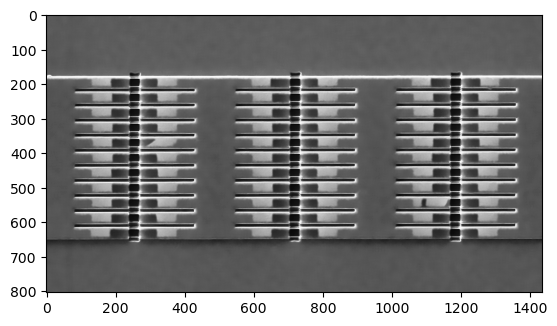

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import copy
from scipy.stats import mode
from scipy import ndimage

img_path = "/home/enrico/Desktop/Wires_Stat/ebr_GenesisF_binary_survey4statistics/DE11_210nm_004.tif"
img = cv2.imread(img_path, 0)
img = cv2.fastNlMeansDenoising(img[100 : img.shape[0] - 200, 
           50 : img.shape[1]- 50],dst=img,h=30)

plt.imshow(img, cmap='Greys_r')
plt.show()

In [2]:

def min_pool(img, sz = (5,2), stride = (5,1)):
    im = copy.deepcopy(img)
    im_size = img.shape

    for i in range(0, im_size[0], stride[0]):
        for j in range(0, im_size[1], stride[1]):
            im[i : i + sz[0], j : j + sz[1]] = np.min(im[i : i + sz[0],j : j + sz[1]])
    return im


In [3]:

def max_pool(img, sz = (5,2), stride = (5,1)):
    im = copy.deepcopy(img)
    im_size = img.shape

    for i in range(0, im_size[0], stride[0]):
        for j in range(0, im_size[1], stride[1]):
            im[i : i + sz[0], j : j + sz[1]] = np.max(im[i : i + sz[0],j : j + sz[1]])
    return im


In [4]:
def cut(A):
    print(A.shape)
    min_pl = min_pool(A)[A.shape[0]//3:2*A.shape[0]//3]
    # plt.imshow(min_pl, cmap='Greys_r')
    # plt.show()
    max_pl = max_pool(A)[A.shape[0]//3:2*A.shape[0]//3]
    # plt.imshow(max_pl, cmap='Greys_r')
    # plt.show()
    
    avg_min = np.min(min_pl, axis=0)
    avg_max = np.max(max_pl, axis=0)
    # plt.plot(avg_min)
    # plt.plot(avg_max)
    
    
    grad_min = np.abs(np.gradient(avg_min))
    grad_max = np.abs(np.gradient(avg_max))
    # plt.plot(grad_min)
    # plt.plot(grad_max)
    # plt.show()

    cut_point_1 = np.argmax(grad_min)+1
    cut_point_2 = np.argmax(grad_max)+1
    print("in cut")
    print(cut_point_1,cut_point_2)
    cut_point = cut_point_1 if cut_point_1>cut_point_2 else cut_point_2

    img1 = A[:,cut_point :]
    return img1

In [5]:
def cut_side(img1 , sides):
    
    for side in sides:
        if side == 1:
            img1 = cut(img1)
        if side == 2:
            img1 = np.fliplr(img1)
            img1 = cut(img1)
            img1 = np.fliplr(img1)
        if side == 3:
            img1 = np.rot90(img1,3)
            img1 = cut(img1)
            img1 = np.rot90(img1)
        if side == 4:
            img1 = np.rot90(img1)
            img1 = cut(img1)
            img1 = np.rot90(img1,3)
    return img1

def split(img1, num):
    arrays = np.array_split(img1,num,axis=1)
    
    if num == 2:
        arrays[1] = np.fliplr(arrays[1])
    return arrays







In [6]:
work_img = copy.deepcopy(img)
arr1 = cut_side(work_img, [1,2,3,4])

(803, 1436)
in cut
82 84
(803, 1352)
in cut
76 72
(1276, 803)
in cut
149 145
(1276, 654)
in cut
169 166


In [7]:
def canny_edge_detect(img, save_ced = False):
    ced = cv2.Canny(img, 20, 150, 1)
    if save_ced:
        cv2.imwrite("ced.tiff", ced)
    return ced

In [8]:
def sobel_filters(img, inv):
    Kx = inv*np.array([[-1, 0, 1],[-1, 0, 1],[-1, 0, 1]], np.float32)
    Ky = np.array([[0,0,0],[0,0,0],[0,0,0]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    # theta = np.arctan2(Iy, Ix)
    
    return G

In [9]:
def gauss_smooth(img, save_gsm = False):
    gsm = cv2.GaussianBlur(img, (7, 7), 0)
    if save_gsm:
        cv2.imwrite("gsm.tiff", gsm)
    return gsm

In [10]:
arr2 = split(arr1, 3)
arr2[0] = cut_side(arr2[0], [2])
arr2[1] = cut_side(arr2[1], [1,2])

arr2[2] = cut_side(arr2[2], [1])

arr3 = []
for i in arr2:
    arr3.extend(split(i, 2))

for j in np.arange(len(arr3)):
    arr3[j]=gauss_smooth(arr3[j])

for x in np.arange(len(arr3)):
    plt.imshow(arr3[x], cmap='Greys_r')
    plt.show()


(485, 426)
in cut
80 77
(485, 425)
in cut
38 39
(485, 386)
in cut
40 36
(485, 425)


KeyboardInterrupt: 

In [ ]:
def hist_equal(img):
    heq = cv2.equalizeHist(img)
    # cv2.imwrite("heq.tiff", heq)
    return heq

In [ ]:
def clahe(img):
    cla_he = cv2.createCLAHE(tileGridSize = (8, 8))
    cla = cla_he.apply(img)
    # cv2.imwrite("cla.tiff", cla)
    return cla

In [ ]:
for i in arr3[0:1]:
    # fig, ax = plt.subplots(ncols=3, figsize =(12,24))
    # mx = np.maximum(sobel_filters(max_pool(i, sz=(2,2),stride=(2,1)),-1),sobel_filters(min_pool(i, sz=(2,2),stride=(2,1)),1))
    # print(mx.shape)
    # ax[0].imshow(, cmap='Greys_r')
    # ax[1].imshow(, cmap='Greys_r')
    mm = copy.deepcopy(i)
    # mp = max_pool(mm, sz=(2,2),stride=(2,1))
    # mn = min_pool(mm, sz=(2,2),stride=(2,1))
    mm = np.rot90(mm)
    mm = split(mm, 11)
    mm = [np.rot90(i,3) for i in mm]
    
    for i,j in enumerate(mm):
        plt.imsave("out"+str(i)+".png",(j-j.min())/(j.max()-j.min()))
        # plt.show()
    
    # # temp = sobel_filters(mp,-1)
    
    # # temp = temp.astype(np.uint8)
    # # print(type(temp[0][0]))
    # # print(type(mp[0][0]))(sobel_filters(mn,1))
    
    
    
    
    # back_edge = canny_edge_detect(sobel_filters(mn,1).astype(np.uint8))
    
    # temp = sobel_filters(mp,-1)
    # temp[np.where(temp<50)]=0
    # front_edge = canny_edge_detect(temp.astype(np.uint8))
    
    
    # maxx = np.maximum(back_edge,front_edge)
    
    # print(back_edge.max(),back_edge.min())
    # print(front_edge.max(),front_edge.min())
    
    # ax[0].imshow(front_edge, cmap='Greys_r')
    # ax[1].imshow(back_edge, cmap='Greys_r')
    
   
    # # maxx = np.rot90(maxx)
    # # maxx = split(maxx,11)
    # ax[2].imshow(maxx, cmap='Greys_r')
    
    # temp[np.where(temp>150)]=255
    # ax[3].imshow(temp, cmap='Greys_r')
    
    fig.show()


In [ ]:
from scipy.signal import savgol_filter


/home/enrico/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


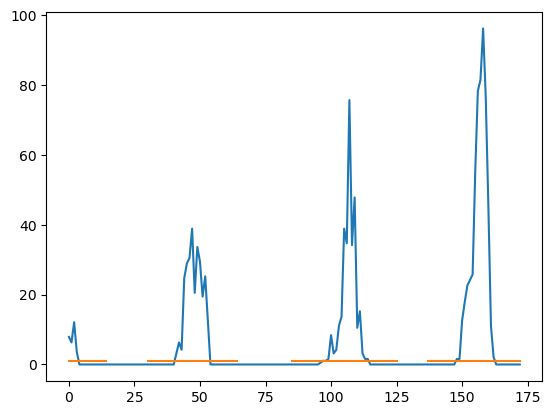

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 nan nan nan nan nan nan nan nan nan nan nan  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [ ]:
avg_min = np.average(maxx, axis=0)
avg_grad = np.gradient(avg_min, axis=0)
avg_grad = savgol_filter(avg_grad, 11, 2)
avg_grad = savgol_filter(avg_grad, 11, 2)




# plt.plot(avg_min)
plt.plot(avg_min)
avg_grad = avg_grad/avg_grad
plt.plot(avg_grad)
plt.show()

print(avg_grad)